In [1]:
from numpy import size
import gc
import random as random
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda
import tensorflow as tf
from scripts import commonUtils as alex

# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
seed=random.randint(1,99999)
size=(100,100)
dataPath='images100'
pool=alex.getSamples(dataPath,size,batchSize=99999,seed=seed,split=0.2)
tf.keras.backend.clear_session()
poolValidation=alex.getSamples(dataPath,batchSize=9999,imgSize=size,seed=seed,training=False,split=0.2)

poolValidation.restPool()
valPool=poolValidation.getBatch(reshae=False)
batch=pool.getBatch(reshae=False)


env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


2025-01-28 02:39:40.685097: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 02:39:40.708152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 02:39:40.708178: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 02:39:40.708183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 02:39:40.711893: I tensorflow/core/platform/cpu_feature_g

Found 8108 files belonging to 1 classes.
Using 6487 files for training.


2025-01-28 02:39:41.884051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 02:39:41.899090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 02:39:41.899369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 8108 files belonging to 1 classes.
Using 1621 files for validation.
1621   1621
got another batch,  0  remaning  we are using  1621
6487   6487
got another batch,  0  remaning  we are using  6487


In [2]:
from modelli import modelli as modelli


In [3]:

def model_builder(hp):
  autoencoder = modelli.Autoencoder()

  hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001,0.005,0.0005])

  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=modelli.costum_loss,
                metrics=['mse',modelli.ssim_loss,modelli.costum_loss])

  return autoencoder
import keras_tuner as kt
batch=pool.getBatch(reshae=False)

tuner = kt.RandomSearch(
    model_builder,
    objective="val_loss",
    max_trials=20,  # Number of models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='my_dir',
    project_name='optimize_lr_batch_size'
)

Reloading Tuner from my_dir/optimize_lr_batch_size/tuner0.json


In [4]:
tuner.search(batch, batch, epochs=150,  validation_data=(valPool, valPool),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)])

In [5]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f""" and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

 and the optimal learning rate for the optimizer
is 0.001.



In [3]:
import datetime


autoencoder = modelli.Autoencoder()



if True:
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=modelli.costum_loss,
                       metrics=['mse',modelli.ssim_loss,modelli.costum_loss])
  log_dir = "logs/fit/autoencoder" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True,histogram_freq=1)
  autoencoder.fit(batch, batch, # Note!
                  epochs=150,
                  shuffle=True,
                  batch_size=256,
                  validation_data=(valPool, valPool),
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=9),tensorboard_callback])
  #del batch

else:
   autoencoder=tf.keras.models.load_model("modelli/BN-RGB-50-NO-RETRAIN",{"ssim_loss":modelli.ssim_loss,"costum_loss":modelli.costum_loss})
          

autoencoder.summary(expand_nested=True)
gc.collect()
tf.keras.backend.clear_session()

Epoch 1/150


2025-01-28 02:39:54.437257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2025-01-28 02:39:56.675383: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbad08468f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-28 02:39:56.675403: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-28 02:39:56.678528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-28 02:39:56.742996: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - 13s 209ms/step - loss: 0.1646 - mse: 0.0892 - ssim_loss: 0.8221 - costum_loss: 0.1646 - val_loss: 0.0865 - val_mse: 0.0496 - val_ssim_loss: 0.7434 - val_costum_loss: 0.0865
Epoch 2/150
26/26 [==============================] - 2s 67ms/step - loss: 0.0668 - mse: 0.0399 - ssim_loss: 0.6713 - costum_loss: 0.0668 - val_loss: 0.0508 - val_mse: 0.0313 - val_ssim_loss: 0.6213 - val_costum_loss: 0.0508
Epoch 3/150
26/26 [==============================] - 2s 67ms/step - loss: 0.0430 - mse: 0.0277 - ssim_loss: 0.5495 - costum_loss: 0.0430 - val_loss: 0.0387 - val_mse: 0.0250 - val_ssim_loss: 0.5528 - val_costum_loss: 0.0387
Epoch 4/150
26/26 [==============================] - 2s 67ms/step - loss: 0.0381 - mse: 0.0247 - ssim_loss: 0.5435 - costum_loss: 0.0381 - val_loss: 0.0363 - val_mse: 0.0237 - val_ssim_loss: 0.5335 - val_costum_loss: 0.0363
Epoch 5/150
26/26 [==============================] - 2s 69ms/step - loss: 0.0356 - mse: 0.0235 - ssim_loss: 0.5139

In [5]:
if True:
    autoencoder.save('modelli/BN-RGB-50-NO-RETRAIN')

INFO:tensorflow:Assets written to: modelli/BN-RGB-50-NO-RETRAIN/assets


INFO:tensorflow:Assets written to: modelli/BN-RGB-50-NO-RETRAIN/assets


In [6]:
log_dir = "logs/fit/autoencoderRevamp" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True,histogram_freq=1)
autoencoderRevamp=modelli.AutoencoderFinal(autoencoder)
#tf.keras.utils.plot_model(autoencoderRevamp.decoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)
opt=tf.keras.optimizers.Adam(learning_rate=0.0005)
autoencoderRevamp.compile(optimizer=opt, loss=modelli.costum_loss, metrics=['mse',modelli.ssim_loss,modelli.costum_loss])
autoencoderRevamp.fit(batch, batch, # Note!
                  epochs=150,
                  shuffle=True,
                  batch_size=256,
                  validation_data=(valPool, valPool),
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15),tensorboard_callback])
gc.collect()
tf.keras.backend.clear_session()
#tf.keras.utils.plot_model(autoencoderRevamp.encoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)

Epoch 1/150
26/26 [==============================] - 5s 111ms/step - loss: 0.0015 - mse: 0.0014 - ssim_loss: 0.0703 - costum_loss: 0.0015 - val_loss: 0.0013 - val_mse: 0.0012 - val_ssim_loss: 0.0644 - val_costum_loss: 0.0013
Epoch 2/150
26/26 [==============================] - 2s 63ms/step - loss: 0.0013 - mse: 0.0012 - ssim_loss: 0.0697 - costum_loss: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012 - val_ssim_loss: 0.0617 - val_costum_loss: 0.0012
Epoch 3/150
26/26 [==============================] - 2s 64ms/step - loss: 0.0013 - mse: 0.0012 - ssim_loss: 0.0666 - costum_loss: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012 - val_ssim_loss: 0.0616 - val_costum_loss: 0.0012
Epoch 4/150
26/26 [==============================] - 2s 64ms/step - loss: 0.0013 - mse: 0.0012 - ssim_loss: 0.0669 - costum_loss: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012 - val_ssim_loss: 0.0622 - val_costum_loss: 0.0012
Epoch 5/150
26/26 [==============================] - 2s 63ms/step - loss: 0.0013 - mse: 0.0012 - ssim_l

In [7]:
if True:
    autoencoderRevamp.save_weights('modelli/BN-RGB-50-RETRAIN.h5')
#autoencoderRevamp.save('modelli/BN-RGB-50-RETRAIN')

In [8]:
import  numpy as np
autoencoder=autoencoderRevamp
n=5
startI=0
a,b = autoencoder.encoder(valPool[0:100])
a=a.numpy()
b=b.numpy()
decoded_imgs = autoencoder.decoder(autoencoder.converter([a,b])).numpy()
from jwt import decode
import matplotlib.pyplot as plt
print(valPool[0].nbytes)
print(a[0].nbytes)
print(b[0].nbytes)

def getStats(encoded,normal):
    shape=(100,100)
    media=0
    result=0
    for i in range(0,len(encoded)):
            dec= encoded[i]
            nor= normal[i]
            for j in range(0,3):
                 media+=0.333*tf.image.ssim(tf.constant(np.reshape(dec[:,:,j],(100,100,1)), dtype='float32'), tf.constant(np.reshape(nor[:,:,j],(100,100,1)), dtype='float32'), max_val=1.0).numpy()
    ssimMedia=round(media/len(encoded),3)
    return [ssimMedia]

print(getStats(decoded_imgs,valPool))

240000
2500
7500
[0.947]


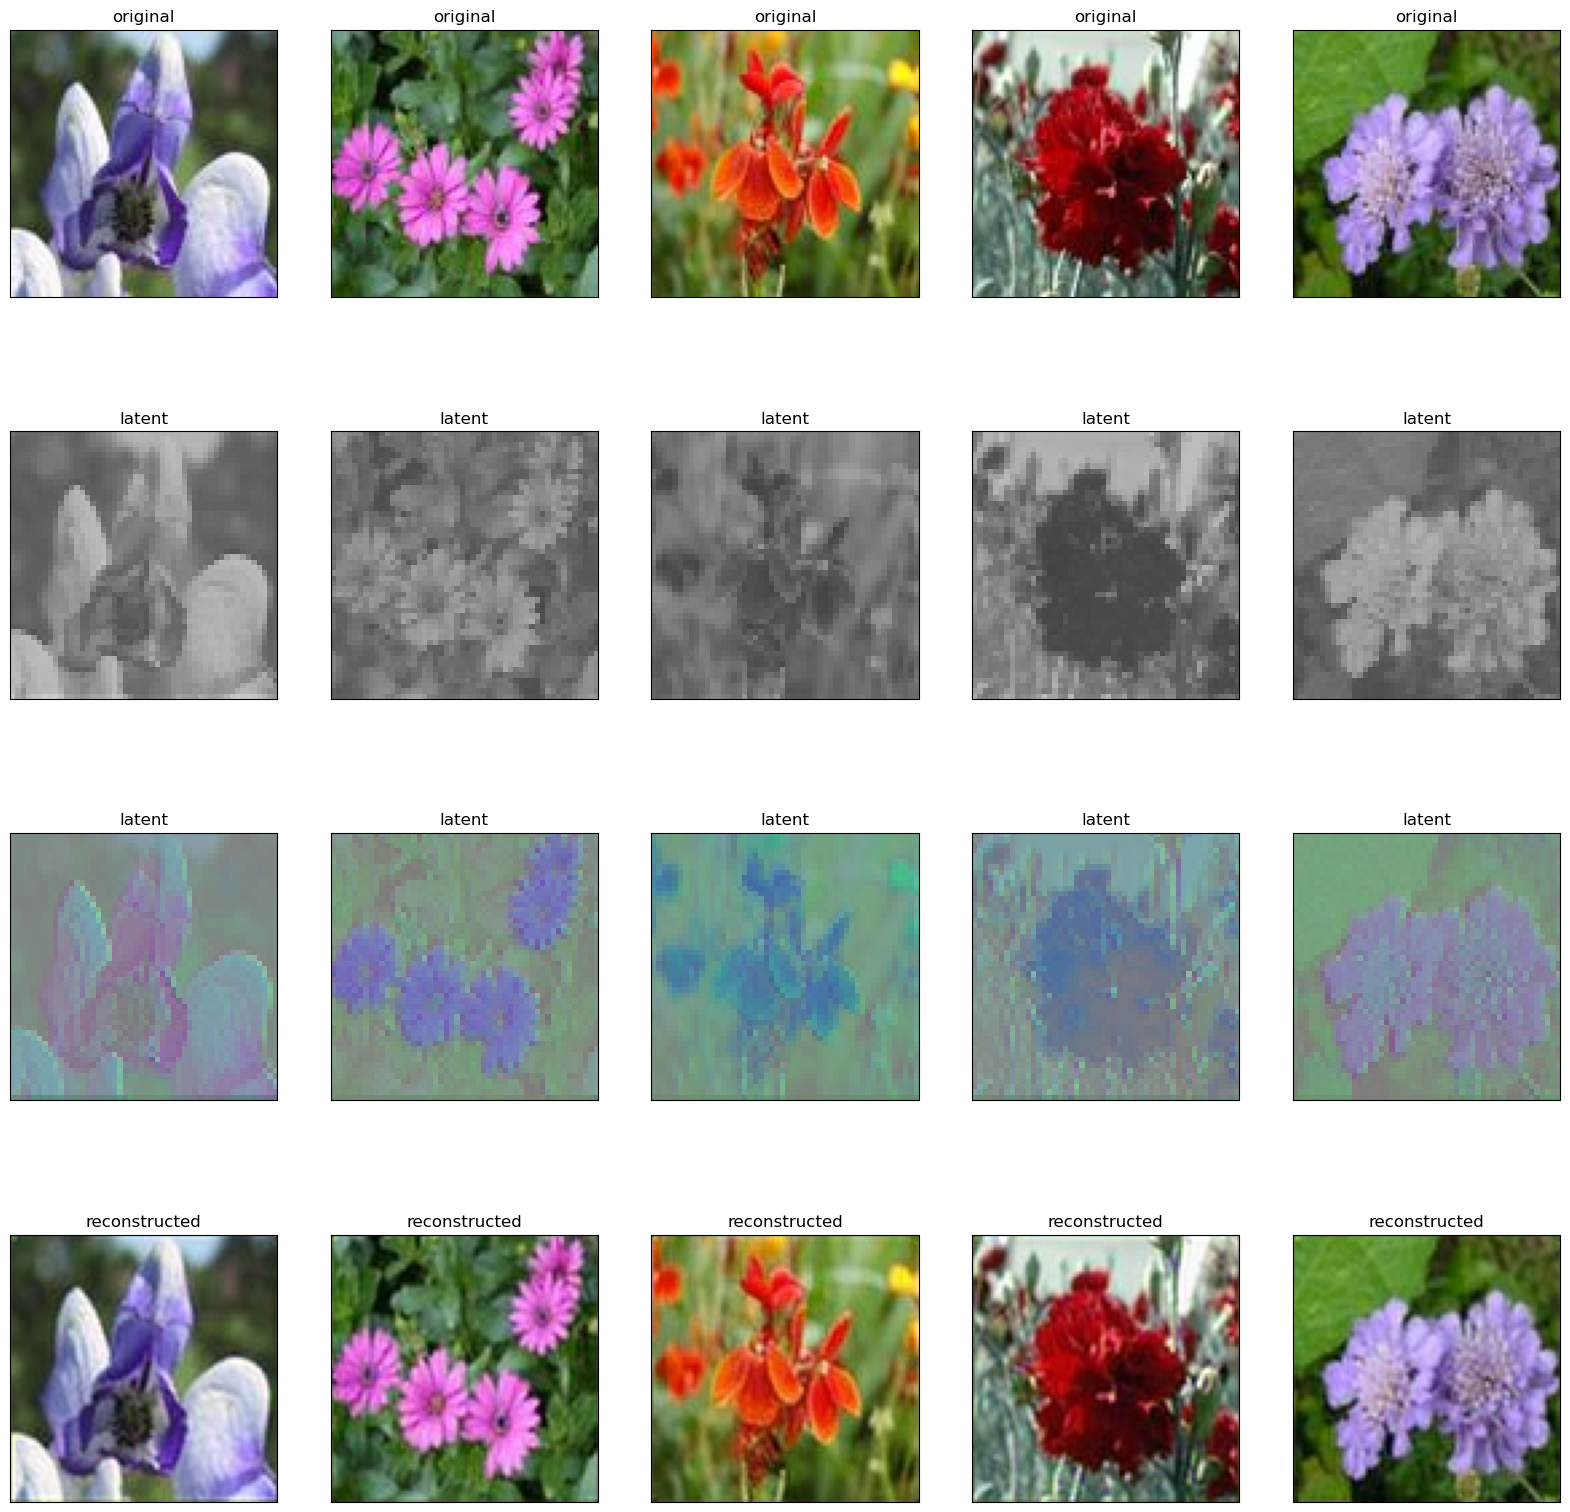

In [9]:
plt.figure(figsize=(20, 20))
startI=0
n=5
for i in range(startI,n):
  # display original
  ax = plt.subplot(4, 5, i-startI + 1)
  plt.imshow(valPool[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(4, 5, i-startI + 1 +5)
  plt.imshow(a[i].reshape((50,50,1)),cmap='gray', vmin=0, vmax=255)
  plt.title("latent")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  ax = plt.subplot(4, 5, i-startI + 1 +2*5)
  plt.imshow(b[i].reshape((50,50,3)))
  plt.title("latent")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display reconstruction
  ax = plt.subplot(4, 5,i-startI + 1 + 3*5)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
startI=n
n+=5

In [10]:
import datetime
autoencoder25 = modelli.Autoencoder(4)



if True:
  autoencoder25.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=modelli.costum_loss,
                       metrics=['mse',modelli.ssim_loss,modelli.costum_loss])
  log_dir = "logs/fit/autoencoder25" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True,histogram_freq=1)
  autoencoder25.fit(batch, batch, # Note!
                  epochs=130,
                  shuffle=True,
                  batch_size=256,
                  validation_data=(valPool, valPool),
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15),tensorboard_callback])
  #del batch

else:
   autoencoder25=tf.keras.models.load_model("modelli/BN-RGB-25-NO-RETRAIN",{"ssim_loss":modelli.ssim_loss,"costum_loss":modelli.costum_loss})
          

autoencoder25.summary(expand_nested=True)
gc.collect()
tf.keras.backend.clear_session()

Epoch 1/130
26/26 [==============================] - 8s 144ms/step - loss: 0.2692 - mse: 0.1386 - ssim_loss: 0.9241 - costum_loss: 0.2692 - val_loss: 0.1391 - val_mse: 0.0752 - val_ssim_loss: 0.8510 - val_costum_loss: 0.1391
Epoch 2/130
26/26 [==============================] - 2s 74ms/step - loss: 0.1282 - mse: 0.0698 - ssim_loss: 0.8357 - costum_loss: 0.1282 - val_loss: 0.1190 - val_mse: 0.0652 - val_ssim_loss: 0.8258 - val_costum_loss: 0.1190
Epoch 3/130
26/26 [==============================] - 2s 75ms/step - loss: 0.1128 - mse: 0.0627 - ssim_loss: 0.7968 - costum_loss: 0.1128 - val_loss: 0.1022 - val_mse: 0.0566 - val_ssim_loss: 0.8041 - val_costum_loss: 0.1022
Epoch 4/130
26/26 [==============================] - 2s 75ms/step - loss: 0.0812 - mse: 0.0462 - ssim_loss: 0.7530 - costum_loss: 0.0812 - val_loss: 0.0566 - val_mse: 0.0329 - val_ssim_loss: 0.7256 - val_costum_loss: 0.0566
Epoch 5/130
26/26 [==============================] - 2s 74ms/step - loss: 0.0534 - mse: 0.0319 - ssim_l

In [11]:
if True:
    autoencoder25.save('modelli/BN-RGB-25-NO-RETRAIN')

INFO:tensorflow:Assets written to: modelli/BN-RGB-25-NO-RETRAIN/assets


INFO:tensorflow:Assets written to: modelli/BN-RGB-25-NO-RETRAIN/assets


In [12]:
log_dir = "logs/fit/autoencoder25Revamp" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True,histogram_freq=1)
autoencoder25Revamp=modelli.AutoencoderFinal(autoencoder25,4)
#tf.keras.utils.plot_model(autoencoderRevamp.decoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder25Revamp.compile(optimizer=opt, loss='mse', metrics=['mse',modelli.ssim_loss,modelli.costum_loss])
autoencoder25Revamp.fit(batch, batch, # Note!
                  epochs=100,
                  shuffle=True,
                  batch_size=256,
                  validation_data=(valPool, valPool),
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15),tensorboard_callback])
#tf.keras.utils.plot_model(autoencoderRevamp.encoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)

  #del batch

Epoch 1/100
26/26 [==============================] - 4s 100ms/step - loss: 0.0081 - mse: 0.0081 - ssim_loss: 0.2153 - costum_loss: 0.0099 - val_loss: 0.0076 - val_mse: 0.0076 - val_ssim_loss: 0.1966 - val_costum_loss: 0.0091
Epoch 2/100
26/26 [==============================] - 2s 64ms/step - loss: 0.0076 - mse: 0.0076 - ssim_loss: 0.1916 - costum_loss: 0.0091 - val_loss: 0.0075 - val_mse: 0.0075 - val_ssim_loss: 0.1917 - val_costum_loss: 0.0090
Epoch 3/100
26/26 [==============================] - 2s 64ms/step - loss: 0.0076 - mse: 0.0076 - ssim_loss: 0.1893 - costum_loss: 0.0090 - val_loss: 0.0075 - val_mse: 0.0075 - val_ssim_loss: 0.1908 - val_costum_loss: 0.0090
Epoch 4/100
26/26 [==============================] - 2s 64ms/step - loss: 0.0076 - mse: 0.0076 - ssim_loss: 0.2011 - costum_loss: 0.0091 - val_loss: 0.0075 - val_mse: 0.0075 - val_ssim_loss: 0.1919 - val_costum_loss: 0.0089
Epoch 5/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0076 - mse: 0.0076 - ssim_l

In [13]:
autoencoder25Revamp.save_weights('modelli/BN-RGB-25-RETRAIN.h5')


In [14]:
import  numpy as np
autoencoder=autoencoder25Revamp
n=5
startI=0
a,b = autoencoder.encoder(valPool[0:100])
a=a.numpy()
b=b.numpy()
decoded_imgs = autoencoder.decoder(autoencoder.converter([a,b])).numpy()
from jwt import decode
import matplotlib.pyplot as plt
print(valPool[0].nbytes)
print(a[0].nbytes)
print(b[0].nbytes)

def getStats(encoded,normal):
    shape=(100,100)
    media=0
    result=0
    for i in range(0,len(encoded)):
            dec= encoded[i]
            nor= normal[i]
            for j in range(0,3):
                 media+=0.333*tf.image.ssim(tf.constant(np.reshape(dec[:,:,j],(100,100,1)), dtype='float32'), tf.constant(np.reshape(nor[:,:,j],(100,100,1)), dtype='float32'), max_val=1.0).numpy()
    ssimMedia=round(media/len(encoded),3)
    return [ssimMedia]

print(getStats(decoded_imgs,valPool))

240000
2500
1875
[0.808]


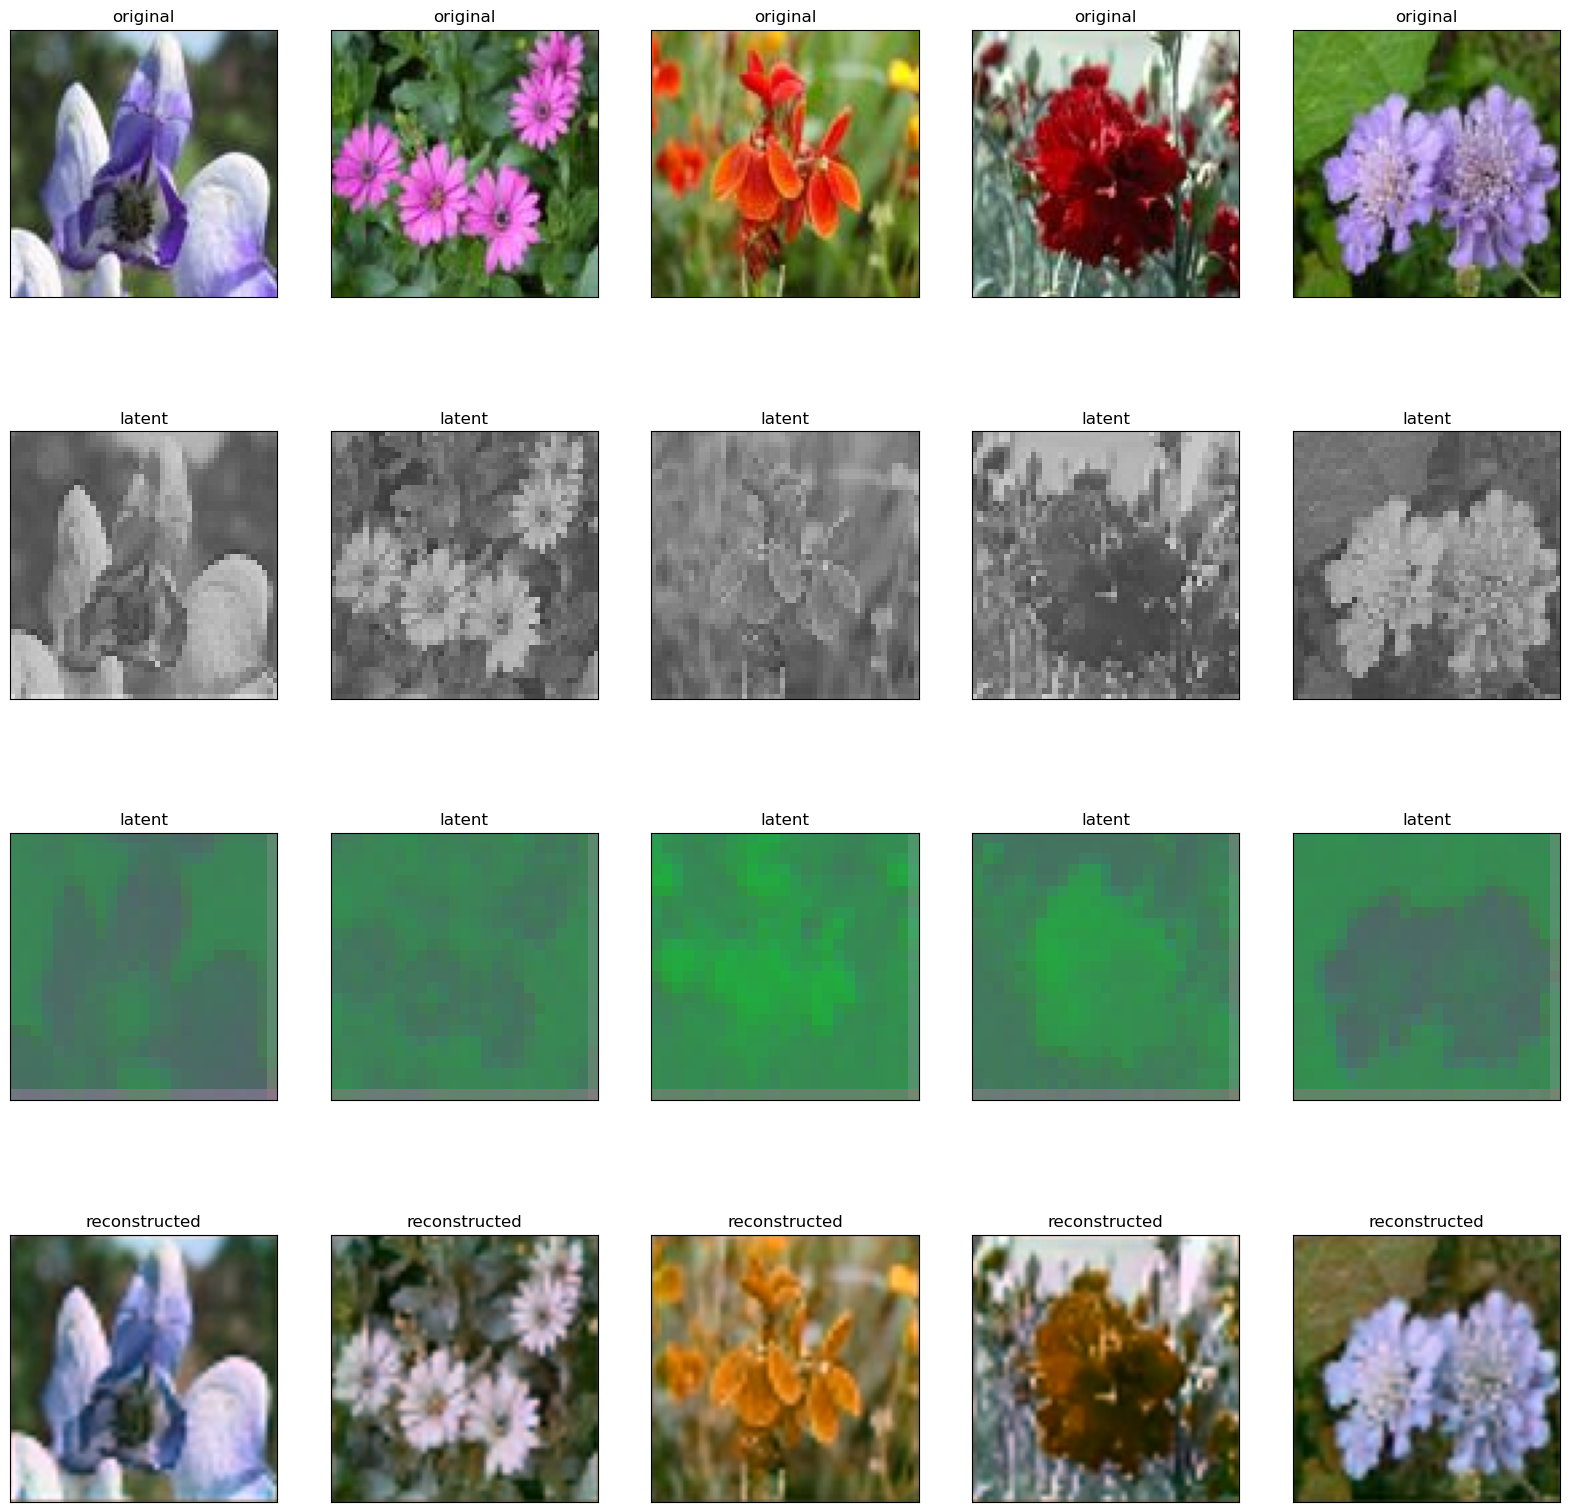

In [15]:
plt.figure(figsize=(20, 20))
startI=0
n=5
for i in range(startI,n):
  # display original
  ax = plt.subplot(4, 5, i-startI + 1)
  plt.imshow(valPool[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(4, 5, i-startI + 1 +5)
  plt.imshow(a[i].reshape((50,50,1)),cmap='gray', vmin=0, vmax=255)
  plt.title("latent")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  ax = plt.subplot(4, 5, i-startI + 1 +2*5)
  plt.imshow(b[i].reshape((25,25,3)))
  plt.title("latent")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display reconstruction
  ax = plt.subplot(4, 5,i-startI + 1 + 3*5)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
startI=n
n+=5